# Training and test script of an ANN to classify OpenMP kernels

In [1]:
import numpy as np
import pandas as pd
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

Load training dataset

In [2]:
dataset = pd.read_csv('train_ANN.csv', sep=';')

In [3]:
dataset.head(5)

,label,PAPI_L1_DCM,PAPI_L3_TCM,PAPI_TOT_INS,PAPI_REF_CYC,PAPI_L2_LDM,PAPI_SR_INS,PAPI_BR_UCN,PAPI_BR_CN,PAPI_BR_TKN,PAPI_BR_MSP,PAPI_FP_OPS,PAPI_L1_LDM,PAPI_L1_STM,PAPI_SP_OPS,PAPI_LD_INS,PAPI_L2_STM,PAPI_TLB_DM,PAPI_L2_DCH
0,Matrix x Vector,0.014623,0.000764,1.733396,1.0,0.000617,0.230399,4.709918e-04,0.267647,0.249635,0.000254,4.580621e-01,0.013099,0.000030,0.458033,0.478215,0.000014,0.000189,1.324517e-02
1,Rows,0.002384,0.000413,0.580806,1.0,0.000250,0.015644,3.338106e-03,0.131571,0.076200,0.000600,1.247113e-05,0.001618,0.000753,0.000000,0.085996,0.000452,0.000021,1.728914e-03
2,Stride,0.005566,0.001708,0.253883,1.0,0.002196,0.004595,5.397193e-04,0.075488,0.041976,0.000106,8.878282e-03,0.002869,0.004118,0.000000,0.035835,0.004351,0.000006,5.781366e-04
3,Stride,0.064821,0.033212,0.280023,1.0,0.032376,0.033533,3.706282e-04,0.038996,0.036310,0.000072,1.013946e-01,0.032499,0.032247,0.000000,0.038231,0.032232,0.003568,1.985738e-04
4,Rows,0.036578,0.005611,0.108556,1.0,0.018724,0.017855,9.334299e-07,0.018924,0.018733,0.000042,6.025008e-09,0.018726,0.017852,0.000000,0.018061,0.017852,0.003108,9.914485e-07


Shuffle dataset and get training labels

In [4]:
from sklearn.utils import shuffle
dataset = shuffle(dataset)
dataset['label'].unique()

array(['Matrix x Matrix', 'Stencil', 'Matrix x Vector', 'Triad', 'Stride',
       'Copy', 'Rows', 'Reduction'], dtype=object)

In [5]:
print(dataset['label'].value_counts())

Rows               103200
Copy               103200
Stride             103200
Triad              103200
Reduction          103200
Matrix x Matrix    102168
Stencil            102168
Matrix x Vector    102168
Name: label, dtype: int64


dataset.head(5)

columns_to_divide = list(dataset.columns)
columns_to_divide.pop(0)
columns_to_divide 

dataset_aux = dataset.copy()
for column in columns_to_divide:
    dataset_aux[column] = dataset[column].div(dataset['PAPI_REF_CYC'], axis=0)
dataset_aux.head(5)
dataset_aux.to_csv('train_ANN.csv',sep=';', index=False)

Divide dataset hardware performance counters and labels

In [6]:
X = dataset.iloc[:,1:19].values
y = dataset.iloc[:,0].values

In [7]:
X[0]

array([2.50420246e-01, 4.50745197e-05, 1.81519228e+00, 1.00000000e+00,
       2.18125721e-02, 2.26743773e-01, 1.58145838e-06, 2.27075268e-01,
       2.26629392e-01, 1.90759389e-04, 4.54075161e-01, 2.50338363e-01,
       1.19468473e-05, 4.54076085e-01, 4.53545435e-01, 1.18331913e-05,
       3.07595849e-07, 2.28241829e-01])

Normalize data

In [8]:
from sklearn.preprocessing import Normalizer
scaler_x = Normalizer()
scaler_x.fit(X)
X_scaled =  scaler_x.transform(X)

Encode labels in numeric categories

In [9]:
from sklearn.preprocessing import LabelEncoder
encoder =  LabelEncoder()
y1 = encoder.fit_transform(y)
Y = pd.get_dummies(y1).values

In [10]:
from keras.constraints import Constraint
from keras import backend as K

class ClipWeights(Constraint):
    def __init__(self, low, high):
        self.low = low
        self.high = high
        
    def __call__(self, weight):
        return K.clip(weight, self.low, self.high)

Using TensorFlow backend.
c:\users\jordi\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\jordi\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\jordi\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

Load keras NN libraries and create empty NN

In [11]:
#Defining the model 
from keras.models import Sequential
from keras.layers import Dense, Dropout, GaussianNoise
from keras.optimizers import Adam


model = Sequential()

Add input layer for the 20 hardware counters
Add one hidden layer
And one output layer
Then compile the model

In [12]:
model.add(Dense(18, activation='selu', input_shape=(18,), kernel_constraint=ClipWeights(-10.0,10.0)))
model.add(Dropout(0.1))
model.add(Dense(16, activation='selu', kernel_constraint=ClipWeights(-10.0,10.0)))
model.add(Dropout(0.1))
model.add(Dense(8, activation='softmax', kernel_constraint=ClipWeights(-10.0,10.0)))

model.compile(Adam(lr=0.001), 'categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 18)                342       
_________________________________________________________________
dropout_1 (Dropout)          (None, 18)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                304       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 136       
Total params: 782
Trainable params: 782
Non-trainable params: 0
_________________________________________________________________


Train the neural network

In [13]:
history = model.fit(X_scaled,Y,batch_size=100,epochs=24,shuffle=True,validation_split=0.20)

Train on 658003 samples, validate on 164501 samples
Epoch 1/24
658003/658003 [==============================] - 8s 12us/step - loss: 0.3768 - acc: 0.8601 - val_loss: 0.1460 - val_acc: 0.9395
Epoch 2/24
658003/658003 [==============================] - 7s 11us/step - loss: 0.1201 - acc: 0.9588 - val_loss: 0.0972 - val_acc: 0.9567
Epoch 3/24
658003/658003 [==============================] - 7s 11us/step - loss: 0.0836 - acc: 0.9726 - val_loss: 0.0618 - val_acc: 0.9814
Epoch 4/24
658003/658003 [==============================] - 7s 11us/step - loss: 0.0694 - acc: 0.9770 - val_loss: 0.0784 - val_acc: 0.9637
Epoch 5/24
658003/658003 [==============================] - 7s 11us/step - loss: 0.0608 - acc: 0.9798 - val_loss: 0.0845 - val_acc: 0.9604
Epoch 6/24
658003/658003 [==============================] - 7s 11us/step - loss: 0.0559 - acc: 0.9816 - val_loss: 0.0400 - val_acc: 0.9925
Epoch 7/24
658003/658003 [==============================] - 8s 12us/step - loss: 0.0531 - acc: 0.9823 - val_loss: 

See the evolution of the model

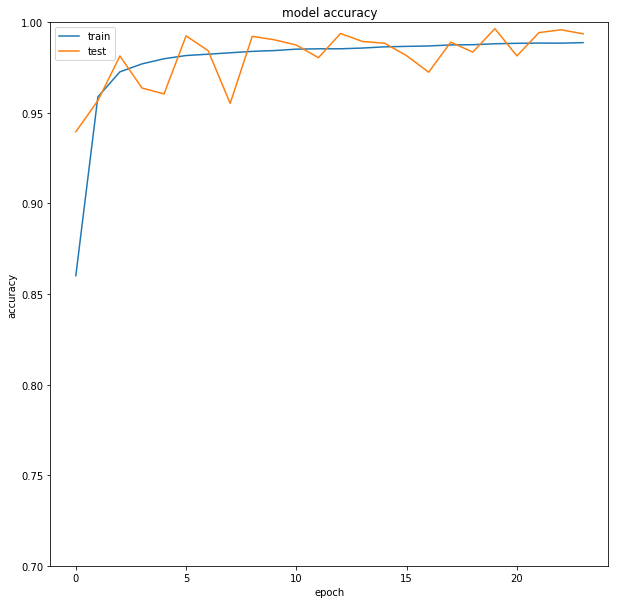

In [15]:
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10
plt.ylim(0.7,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


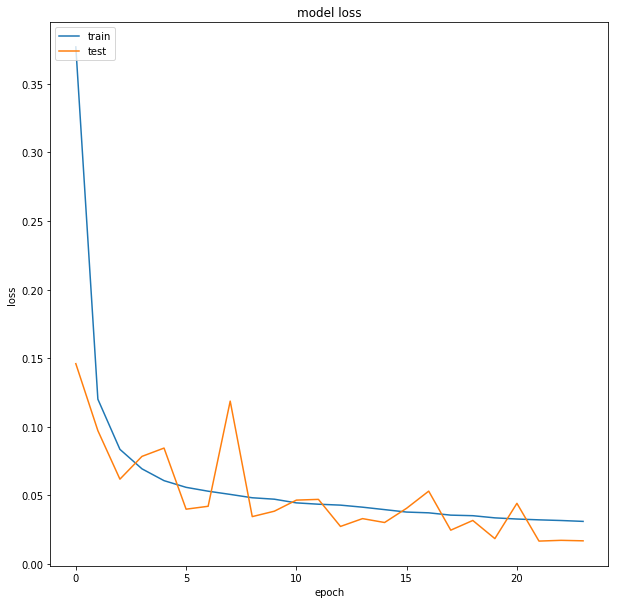

In [16]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Import validation dataset

In [ ]:
dataset_pred = pd.read_csv('test_ANN.csv', sep=';')

In [ ]:
dataset_pred.head(4)

Normalize data to cycles
This dataset needs normalizing because storing the normalized dataset increases the size by aprox. 3x-4x

In [ ]:
dataset_pred1 = dataset_pred.copy()
cols = list(dataset_pred.columns)
cols.pop(0)
print(cols)
for col in cols:
    dataset_pred1[col] = dataset_pred[col].div(dataset_pred['PAPI_REF_CYC'], axis=0)
dataset_pred1.head(4)

In [ ]:
dataset_pred = dataset_pred1.copy()
del dataset_pred1

Divide dataset hardware performance counters and labels

In [ ]:
X_pred = dataset_pred.iloc[:,1:21].values
y_pred = dataset_pred.iloc[:,0].values

Normalize the data

In [ ]:
X_pred_scaled = scaler_x.fit_transform(X_pred)

Use the network to predict the labels and transform the output to the pattern's labels

In [ ]:
from keras.utils import to_categorical
predictions = model.predict_classes(X_pred_scaled)
prediction_ = np.argmax(to_categorical(predictions), axis = 1)
prediction_ = encoder.inverse_transform(prediction_)

Make prediction readable

In [ ]:
predicted_as={}
for i, j in zip(prediction_ , y_pred):
    pattern_as = str(j + " -- predicted as: " + i)
    if pattern_as not in predicted_as:
        predicted_as[pattern_as] = 0
    predicted_as[pattern_as] = predicted_as[pattern_as] + 1

Print predictions

In [ ]:
for i in sorted(predicted_as):
    print ( i , " --> ", predicted_as[i] )
